<a href="https://colab.research.google.com/github/santiagosaldivar/APMTH115/blob/main/Copy_of_Final_Project_SaldivarSantiago.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Santiago Saldivar

Dr. Michael Brenner

Applied Mathematics 115

May 8, 2024

PART 2: The Adjusted Model

In [148]:
# import necessary packages
import numpy as np # for many mathematical computations
import scipy # for mathematics as well
import pandas as pd # for handling data
import random # for setting seeds
import matplotlib.pyplot as plt # for graphing
import statistics

In [90]:
# import dataset
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/Senior year/APMTH 115/Final Project/Data/KaggleMatches.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-90-bc7c6769bf81>:5: DtypeWarning: Columns (3,8,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/My Drive/Senior year/APMTH 115/Final Project/Data/KaggleMatches.csv')


In [91]:
# check dataset
print(df)

       tourney_id  tourney_name surface draw_size tourney_level tourney_date  \
0       2019-M020      Brisbane    Hard        32             A   2018-12-31   
1       2019-M020      Brisbane    Hard        32             A   2018-12-31   
2       2019-M020      Brisbane    Hard        32             A   2018-12-31   
3       2019-M020      Brisbane    Hard        32             A   2018-12-31   
4       2019-M020      Brisbane    Hard        32             A   2018-12-31   
...           ...           ...     ...       ...           ...          ...   
373431  1978-W001  Wightman Cup  Carpet       0.0             D   1978-11-03   
373432  1978-W001  Wightman Cup  Carpet       0.0             D   1978-11-03   
373433  1978-W001  Wightman Cup  Carpet       0.0             D   1978-11-03   
373434  1978-W001  Wightman Cup  Carpet       0.0             D   1978-11-03   
373435  1978-W001  Wightman Cup  Carpet       0.0             D   1978-11-03   

        match_num  winner_id winner_see

In [92]:
# limit dataset to after 1998, 20 years before the match
df['tourney_date'] = pd.to_datetime(df['tourney_date']) # Convert the string column to datetime format
after_date = pd.to_datetime('1998-12-31')
date_mask = df['tourney_date'] >= after_date # did the match occur in 2016 or later?

filtered_df = df[date_mask]
print(filtered_df)
#check the dates
#df_sorted = filtered_df.sort_values(by='tourney_date')
#print(df_sorted)

                    tourney_id            tourney_name surface draw_size  \
0                    2019-M020                Brisbane    Hard        32   
1                    2019-M020                Brisbane    Hard        32   
2                    2019-M020                Brisbane    Hard        32   
3                    2019-M020                Brisbane    Hard        32   
4                    2019-M020                Brisbane    Hard        32   
...                        ...                     ...     ...       ...   
297981  2008-W-WT-QAT-01A-2008  WTA Tour Championships    Hard         4   
297982  2008-W-WT-QAT-01A-2008  WTA Tour Championships    Hard         4   
297983  2008-W-WT-QAT-01A-2008  WTA Tour Championships    Hard         4   
297984  2008-W-WT-QAT-01A-2008  WTA Tour Championships    Hard         4   
297985  2008-W-WT-QAT-01A-2008  WTA Tour Championships    Hard         4   

       tourney_level tourney_date  match_num  winner_id winner_seed  \
0               

In [93]:
# only include rows for women's matches
# wta marks a women's tournament match
filter_value = 'wta'

# Create boolean mask based on WTA being in column
value_mask = filtered_df['league'] == filter_value

# Subset the dataframe using the mask
filtered_df = filtered_df[value_mask]

print(filtered_df) # check to make sure the dataset looks okay

                    tourney_id            tourney_name surface draw_size  \
213214  1999-W-SL-AUS-01A-1999         Australian Open    Hard     128.0   
213215  1999-W-SL-AUS-01A-1999         Australian Open    Hard     128.0   
213216  1999-W-SL-AUS-01A-1999         Australian Open    Hard     128.0   
213217  1999-W-SL-AUS-01A-1999         Australian Open    Hard     128.0   
213218  1999-W-SL-AUS-01A-1999         Australian Open    Hard     128.0   
...                        ...                     ...     ...       ...   
297981  2008-W-WT-QAT-01A-2008  WTA Tour Championships    Hard         4   
297982  2008-W-WT-QAT-01A-2008  WTA Tour Championships    Hard         4   
297983  2008-W-WT-QAT-01A-2008  WTA Tour Championships    Hard         4   
297984  2008-W-WT-QAT-01A-2008  WTA Tour Championships    Hard         4   
297985  2008-W-WT-QAT-01A-2008  WTA Tour Championships    Hard         4   

       tourney_level tourney_date  match_num  winner_id winner_seed  \
213214          

In [94]:
# order ELO training data by date, name, and round
training_df = filtered_df.sort_values(by = ['tourney_date', 'tourney_name', 'round'])\

# Define custom sorting order for rounds of a match
custom_order = ['BR', 'RR', 'R128', 'R64', 'R32', 'R16', 'QF', 'SF', 'F']

# Sort DataFrame by 'round' column using custom order
training_df_sorted = training_df.sort_values(by='round', key=lambda x: x.map({k: i for i, k in enumerate(custom_order)}))

# limit training dataframe to before Aug, 2018 (so we can predict 2018 using ELO)
before_date = pd.to_datetime('2018-08-01')
date_mask_2 = training_df_sorted['tourney_date'] <= before_date
training_df_sorted = training_df_sorted[date_mask_2]

In [95]:
# restrict dataset to players who played in the US open.
# this is for finding the 2018 US Open tourney_id, not for the ELO Score dataset
# Specific filter value to search for
filter_value = 'US Open'

# Create boolean mask based on US Open being in column
value_mask = filtered_df['tourney_name'] == filter_value

# Subset the dataframe using the mask
US_Open = filtered_df[value_mask]

# get unique id for US Open 2018
print(US_Open['tourney_id'].unique()) #note: tourney_id is 2018-560

['1999-W-SL-USA-01A-1999' '2012-W-SL-USA-01A-2012'
 '2006-W-SL-USA-01A-2006' '2007-W-SL-USA-01A-2007'
 '2013-W-SL-USA-01A-2013' '2005-W-SL-USA-01A-2005'
 '2011-W-SL-USA-01A-2011' '2010-W-SL-USA-01A-2010'
 '2004-W-SL-USA-01A-2004' '2000-W-SL-USA-01A-2000'
 '2014-W-SL-USA-01A-2014' '2015-W-SL-USA-01A-2015'
 '2001-W-SL-USA-01A-2001' '2017-560' '2003-W-SL-USA-01A-2003'
 '2002-W-SL-USA-01A-2002' '2016-560' '2018-560' '2009-W-SL-USA-01A-2009'
 '2008-W-SL-USA-01A-2008']


In [96]:
# get only those women that played in US open in 2018
# first obtain the 2018 US Open matches (women only)
US_Open_2018 = US_Open.loc[US_Open['tourney_id'] == '2018-560']

# obtain the top four players
print(US_Open_2018['winner_name'][US_Open_2018['round'] == 'F'].values[0]) #1: Naomi Osaka
print(US_Open_2018['loser_name'][US_Open_2018['round'] == 'F'].values[0]) #2: Serena Williams
print(US_Open_2018['loser_name'][US_Open_2018['round']=='SF'].values) #Anastasija Sevastova, Madison Keys
# Top four: Naomi Osaka, Serena Williams, (Anastasija Sevastova / Madison Keys).

# next, obtain the list of women that played in these matches
winners_and_losers = pd.concat([US_Open_2018['winner_name'], US_Open_2018['loser_name']])

# now, eliminate repeat names
unique_women = winners_and_losers.unique().tolist()
print(unique_women)
print(US_Open_2018['round'].unique()) # rounds to be used later

Naomi Osaka
Serena Williams
['Anastasija Sevastova' 'Madison Keys']
['Kaia Kanepi', 'Jil Belen Teichmann', 'Vania King', 'Rebecca Peterson', 'Serena Williams', 'Carina Witthoeft', 'Camila Giorgi', 'Venus Williams', 'Garbine Muguruza', 'Karolina Muchova', 'Lucie Safarova', 'Ashleigh Barty', 'Maria Sakkari', 'Sofia Kenin', 'Ana Bogdan', 'Karolina Pliskova', 'Sloane Stephens', 'Anhelina Kalinina', 'Victoria Azarenka', 'Daria Gavrilova', 'Barbora Zahlavova Strycova', 'Lara Arruabarrena', 'Vera Lapko', 'Elise Mertens', 'Julia Goerges', 'Ekaterina Makarova', 'Claire Liu', 'Anastasija Sevastova', 'Qiang Wang', 'Irina Camelia Begu', 'Tatjana Maria', 'Elina Svitolina', 'Caroline Garcia', 'Monica Puig', 'Kristina Mladenovic', 'Carla Suarez Navarro', 'Maria Sharapova', 'Sorana Cirstea', 'Taylor Townsend', 'Jelena Ostapenko', 'Madison Keys', 'Bernarda Pera', 'Aleksandra Krunic', 'Kirsten Flipkens', 'Dominika Cibulkova', 'Su Wei Hsieh', 'Johanna Larsson', 'Angelique Kerber', 'Petra Kvitova', 'Yafan

131.7571204402084


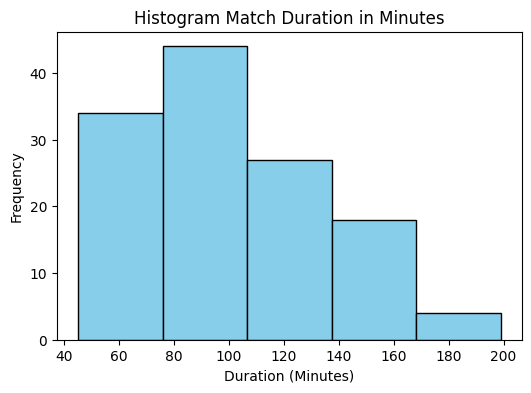

In [97]:
# calculate aspects of US Open to be used later
mean_mins = US_Open_2018['minutes'].mean() # mean length of matches
sd_mins = US_Open_2018['minutes'].std() # SD of matches
upper_bound_mins = mean_mins + sd_mins # mean + 1 SD for duration
print(upper_bound_mins)

# get a sense for the duration of matches via a histogram of 2018 US Open Matches
plt.figure(figsize=(6,4))
US_Open_2018['minutes'].hist(bins=5, color='skyblue', edgecolor='black')  # You can adjust the number of bins as needed
plt.title('Histogram Match Duration in Minutes')
plt.xlabel('Duration (Minutes)')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

Next, create a dictionary which stores each players ELO scores and updates them as each game goes through.

QUESTION: Do I need two dictionaries, one for ELO scores and one for probabilities of winning (converted from ELO scores)?

In [98]:
#define logistic function (utility)
def logistic(x):
    return 1 / (1 + 10**-x)

#given two ELO scores, compute P(A wins over B)
def expected_game_score(team_a_elo, team_b_elo, S=400):
    return logistic((team_a_elo - team_b_elo)/S)

In [99]:
#set up initial elo scores - same for each team
INITIAL_ELO = 1500
INITIAL_PENALTY = 0
PLAYER_ELO = dict([(player,[INITIAL_ELO]) for player in sorted(unique_women)])
players_scoring = dict([(player, 0) for player in sorted(unique_women)])

# learning constant
K = 20

In [100]:
# determine initial ELO Scores of players (based on sorted training df)
counter = 0

for index, row in training_df_sorted.iterrows(): #index: current row number

    # check if the players are in the 2018 US Open
    if row['winner_name'] in unique_women and row['loser_name'] in unique_women:
      counter += 1
      winner = row['winner_name']
      loser = row['loser_name']

      #get latest elo scores
      elo_winner = PLAYER_ELO[winner][-1]
      elo_loser = PLAYER_ELO[loser][-1]

      #calculate prob of winning for each team
      p_winner = expected_game_score(elo_winner, elo_loser)
      p_loser = expected_game_score(elo_loser, elo_winner) #should be 1 - p_winner

      # calculate and append new elo scores to the dictionary
      new_elo_winner = elo_winner + K * (1 - p_winner)
      new_elo_loser = elo_loser + K * (0 - p_loser)

      PLAYER_ELO[winner].append(new_elo_winner)
      PLAYER_ELO[loser].append(new_elo_loser)

In [101]:
print("Number of matches used to determine ELO scores:", counter)
print(PLAYER_ELO['Serena Williams']) # example list value in dictionary.

Number of matches used to determine ELO scores: 8181
[1500, 1510.0, 1519.71225631668, 1509.1535180586025, 1518.8901195702995, 1528.3469533382474, 1536.444116333687, 1544.8194032688305, 1553.5365055644977, 1541.7474955139396, 1550.0057036402332, 1557.333910592964, 1566.4877225805617, 1577.4034578343455, 1585.125943458668, 1592.795031182397, 1600.643709242162, 1607.6115141898672, 1595.2106041738255, 1603.7096652284922, 1611.0169895458591, 1617.9502252872876, 1624.5030644669844, 1630.5552874805276, 1636.0366633624706, 1643.0414290645165, 1648.4221893029637, 1654.9411406153888, 1661.6013912393112, 1666.9752170338988, 1673.0454346183146, 1679.0282477544122, 1682.54093786363, 1670.5218069304467, 1676.2775801400555, 1683.2866126255003, 1687.8558378334226, 1694.4078318361114, 1699.7723736255912, 1704.3009166319284, 1709.5613854179792, 1714.919070029874, 1721.5992355571223, 1727.2813283703754, 1735.027725003404, 1740.1865762799043, 1744.874488021157, 1749.8225393843563, 1753.9084113754463, 1758

In [102]:
# Extract last value for each key into a condensed dictionary
last_values = {key: values[-1] for key, values in PLAYER_ELO.items()}
print(last_values)

{'Agnieszka Radwanska': 1641.1270878079506, 'Ajla Tomljanovic': 1409.2635224101384, 'Aleksandra Krunic': 1396.5977897919536, 'Aliaksandra Sasnovich': 1483.0596844666643, 'Alison Riske': 1492.764205122817, 'Alison Van Uytvanck': 1431.449868483318, 'Alize Cornet': 1521.4548587793145, 'Amanda Anisimova': 1537.8805454770425, 'Ana Bogdan': 1414.8231818211814, 'Anastasia Pavlyuchenkova': 1618.5624319858625, 'Anastasija Sevastova': 1492.9065928493064, 'Andrea Petkovic': 1500.7559023802346, 'Anett Kontaveit': 1530.6667308044725, 'Angelique Kerber': 1642.6278174578251, 'Anhelina Kalinina': 1477.417071663195, 'Anna Blinkova': 1427.9092756433242, 'Anna Kalinskaya': 1422.9481394198633, 'Anna Karolina Schmiedlova': 1442.5246954260103, 'Arantxa Rus': 1387.9269577477519, 'Aryna Sabalenka': 1524.9575451595786, 'Ashleigh Barty': 1531.4834118658346, 'Asia Muhammed': 1483.8305593304738, 'Barbora Zahlavova Strycova': 1437.6538613192256, 'Belinda Bencic': 1571.2541732656068, 'Bernarda Pera': 1478.355981023

In [103]:
# Create DataFrame from condensed dictionary: Player | Elo Score
last_values_df = pd.DataFrame(list(last_values.items()), columns=['Player', 'Elo Score'])
#elo_score_agnieszka = last_values_df.loc[last_values_df['Player'] == 'Agnieszka Radwanska', 'Elo Score'].values[0]

In [122]:
# add to columns to df: mean match duration, std deviation duration
# mean and std deviation recorded for US Open but also all previous matches post-1998
for i in range(len(last_values_df)):
  player = last_values_df.iloc[i]['Player'] # player name
  elo = last_values_df.iloc[i]['Elo Score'] # elo score of player
  subset = US_Open_2018[(US_Open_2018['winner_name'] == player) | (US_Open_2018['loser_name'] == player)]
  last_values_df.at[i, 'mean_dur'] = subset['minutes'].mean()
  last_values_df.at[i, 'SD_dur'] = subset['minutes'].std()

  subset2 = training_df_sorted[(training_df_sorted['winner_name'] == player) | (training_df_sorted['loser_name'] == player)]
  last_values_df.at[i, 'mean_dur_all'] = subset2['minutes'].mean()
  last_values_df.at[i, 'SD_dur_all'] = subset2['minutes'].std()
  last_values_df.at[i, 'threshold'] = subset2['minutes'].std() +subset2['minutes'].mean()


last_values_df['Match Durations'] = [[] for _ in range(len(last_values_df))]
print(last_values_df)
avg_std_dur = last_values_df['SD_dur'].mean() # about 27.62. Using this because some of the standard deviations seem rather high.

                    Player    Elo Score    mean_dur     SD_dur  mean_dur_all  \
0      Agnieszka Radwanska  1636.746332   86.000000        NaN     98.194245   
1         Ajla Tomljanovic  1400.768221  110.500000  61.518290     93.339286   
2        Aleksandra Krunic  1390.678588  100.666667  38.552994     85.588235   
3    Aliaksandra Sasnovich  1475.544972   85.333333  31.895663    100.191011   
4             Alison Riske  1298.146705  120.000000        NaN    103.932773   
..                     ...          ...         ...        ...           ...   
123        Whitney Osuigwe  1488.767701   73.000000        NaN     87.000000   
124             Yafan Wang  1387.361512  117.000000  14.142136    104.089286   
125       Yanina Wickmayer  1391.573469   72.000000        NaN     94.885417   
126       Yulia Putintseva  1330.445820  125.000000        NaN    106.985075   
127           Zarina Diyas  1393.064170   95.000000        NaN     91.671875   

     SD_dur_all   threshold Match Durat

In [105]:
# the round of 128 will have the same grouping of players as before
random.seed(10) # set seed
# first get the names of the players
US_Open_2018_r128 = US_Open_2018.loc[US_Open_2018['round'] == 'R128']
round128players = [(row['winner_name'], row['loser_name']) for index, row in US_Open_2018_r128.iterrows()]

In [106]:
# max/min ELO Scores
max_elo = max(last_values_df['Elo Score'])
min_elo = min(last_values_df['Elo Score'])
diff_elo = max_elo-min_elo
# max/min match durations
max_dur = max(US_Open_2018['minutes'])
min_dur = min(US_Open_2018['minutes'])
diff_dur = max_dur - min_dur

In [107]:
# get the latest elo score for players (at start of 2018) as a dictionary
last_values_dict = {}

for key, value in PLAYER_ELO.items():
    last_values_dict[key] = value[-1]

print(last_values_dict)
print(len(last_values_dict))

{'Agnieszka Radwanska': 1641.1270878079506, 'Ajla Tomljanovic': 1409.2635224101384, 'Aleksandra Krunic': 1396.5977897919536, 'Aliaksandra Sasnovich': 1483.0596844666643, 'Alison Riske': 1492.764205122817, 'Alison Van Uytvanck': 1431.449868483318, 'Alize Cornet': 1521.4548587793145, 'Amanda Anisimova': 1537.8805454770425, 'Ana Bogdan': 1414.8231818211814, 'Anastasia Pavlyuchenkova': 1618.5624319858625, 'Anastasija Sevastova': 1492.9065928493064, 'Andrea Petkovic': 1500.7559023802346, 'Anett Kontaveit': 1530.6667308044725, 'Angelique Kerber': 1642.6278174578251, 'Anhelina Kalinina': 1477.417071663195, 'Anna Blinkova': 1427.9092756433242, 'Anna Kalinskaya': 1422.9481394198633, 'Anna Karolina Schmiedlova': 1442.5246954260103, 'Arantxa Rus': 1387.9269577477519, 'Aryna Sabalenka': 1524.9575451595786, 'Ashleigh Barty': 1531.4834118658346, 'Asia Muhammed': 1483.8305593304738, 'Barbora Zahlavova Strycova': 1437.6538613192256, 'Belinda Bencic': 1571.2541732656068, 'Bernarda Pera': 1478.355981023

In [108]:
# check how Dictionary looks
#PLAYER_ELO

In [109]:
# Define function to assign probabilities based on ELO Scores
def convert_elo_to_pair_probabilities(elo_scores):
    """
    Converts a list of ELO scores to a matrix of pairwise winning probabilities.

    Args:
        elo_scores: A list of ELO scores for each team.

    Returns:
        A NumPy array of pairwise winning probabilities.
    """
    # get player names and number of players
    player_names = elo_scores['Player'].tolist()
    N_players = len(elo_scores)

    # Create a dictionary to store pairwise probabilities for each team
    pairwise_probabilities = {}
    for player in player_names:
        pairwise_probabilities[player] = {}

  # Calculate the probability of each team winning against each other team.
    for i in range(N_players):

        player1 = player_names[i]
        elo1 = elo_scores.loc[i, 'Elo Score']
        pairwise_probabilities[player1][player1] = 0.5

        for j in range(i + 1, N_players):
            player2 = player_names[j]
            elo2 = elo_scores.loc[j, 'Elo Score']

            probability_team1_wins = expected_game_score(elo1, elo2)
            pairwise_probabilities[player1][player2] = probability_team1_wins
            pairwise_probabilities[player2][player1] = 1 - probability_team1_wins

    return pairwise_probabilities

In [110]:
 # calculate and append new elo scores to the list
def elo_update(winner, loser, last_values_df, K=20):
  #get latest elo scores
  winner_loc = last_values_df['Player'] == winner
  loser_loc = last_values_df['Player'] == loser

  elo_winner = last_values_df.loc[winner_loc, 'Elo Score'].values[0]
  elo_loser = last_values_df.loc[loser_loc, 'Elo Score'].values[0]

  #calculate prob of winning for each team
  p_winner = expected_game_score(elo_winner, elo_loser)
  p_loser = expected_game_score(elo_loser, elo_winner) #should be 1 - p_winner

  new_elo_winner = elo_winner + K * (1 - p_winner)
  new_elo_loser = elo_loser + K * (0 - p_loser)

  last_values_df.loc[winner_loc, 'Elo Score'] = new_elo_winner
  last_values_df.loc[loser_loc, 'Elo Score'] = new_elo_loser

  # update match length
  elo_discrepancy = abs(elo_winner - elo_loser)
  frac = (diff_elo - elo_discrepancy) / diff_elo
  norm_mean = min_dur + (frac * diff_dur)
  new_match_duration = np.random.normal(norm_mean, sd_mins) #sd_mins is the standard deviation of US Open 2018 matches
  last_values_df.loc[winner_loc, 'Match Durations'].iloc[0].append(new_match_duration)
  last_values_df.loc[loser_loc, 'Match Durations'].iloc[0].append(new_match_duration)

  # penalize winner if match took significantly longer than mean match duration
  threshold = last_values_df.loc[winner_loc, 'threshold'].values[0]
  sd_winner = last_values_df.loc[winner_loc, 'SD_dur_all'].values[0]
  if new_match_duration > threshold:
    penalty = 1-((new_match_duration - threshold) / sd_winner)
    if penalty < 0.95:
      penalty = 0.95
    new_elo_winner = penalty * new_elo_winner
    last_values_df.loc[winner_loc, 'Elo Score'] = new_elo_winner

  # update probability matrix
  P = convert_elo_to_pair_probabilities(last_values_df)

In [111]:
# create pairwise prob. matrix
P = convert_elo_to_pair_probabilities(last_values_df)
print(P)

{'Agnieszka Radwanska': {'Agnieszka Radwanska': 0.5, 'Ajla Tomljanovic': 0.7916193122114995, 'Aleksandra Krunic': 0.8033908825537334, 'Aliaksandra Sasnovich': 0.7129815648283003, 'Alison Riske': 0.7014150693638249, 'Alison Van Uytvanck': 0.7697675435260296, 'Alize Cornet': 0.6657196728554554, 'Amanda Anisimova': 0.6443591475944429, 'Ana Bogdan': 0.7862907184804168, 'Anastasia Pavlyuchenkova': 0.532427569494111, 'Anastasija Sevastova': 0.701243380190399, 'Andrea Petkovic': 0.6916920023679922, 'Anett Kontaveit': 0.6538172194805187, 'Angelique Kerber': 0.4978402898564101, 'Anhelina Kalinina': 0.7195822958377885, 'Anna Blinkova': 0.7733597523361809, 'Anna Kalinskaya': 0.7783262346482518, 'Anna Karolina Schmiedlova': 0.7582753427628401, 'Arantxa Rus': 0.8111556935170476, 'Aryna Sabalenka': 0.6612177506278988, 'Ashleigh Barty': 0.6527523819238444, 'Asia Muhammed': 0.7120726198153267, 'Barbora Zahlavova Strycova': 0.7633773957942658, 'Belinda Bencic': 0.5992211209046027, 'Bernarda Pera': 0.71

In [112]:
def round128(round128players, P, last_values_df):
  # create empty winners list
  winners128 = []

  # for loop for each matching
  for matchup in round128players:
    player1 = matchup[0]
    player2 = matchup[1]

    probability = np.random.uniform()
    if probability < P[player1][player2]:
      winner = player1
      loser = player2
    else:
      winner = player2
      loser = player1
    winners128.append(winner)

    # update elo
    elo_update(winner, loser, last_values_df, 20)

  return winners128, P, last_values_df

In [113]:
def round64(round64players, P, last_values_df):
  placeholder = 0
  winners64 = []
  for i in range(len(round64players) // 2):
    player1 = round64players[placeholder]
    player2 = round64players[placeholder + 1]

    # calculate differences in

    # conduct match (who wins?)
    probability = np.random.uniform()
    if probability < P[player1][player2]:
        winner = player1
        loser = player2
    else:
      winner = player2
      loser = player1
    winners64.append(winner)

    placeholder = placeholder + 2

    elo_update(winner, loser, last_values_df, 20)

  return winners64, P, last_values_df

In [114]:
# simulate round of 32 (R32)
def round32(round32players, P, last_values_df):
  placeholder = 0
  winners32 = []
  for i in range(len(round32players) // 2):
    player1 = round32players[placeholder]
    player2 = round32players[placeholder + 1]
    probability = np.random.uniform()
    if probability < P[player1][player2]:
        winner = player1
        loser = player2
    else:
      winner = player2
      loser = player1
    winners32.append(winner)
    placeholder = placeholder + 2

    elo_update(winner, loser, last_values_df, 20)

  return winners32, P, last_values_df

In [115]:
# simulate round of 16 (R16)
def round16(round16players, P, last_values_df):
  placeholder = 0
  winners16 = []
  for i in range(len(round16players) // 2):
    player1 = round16players[placeholder]
    player2 = round16players[placeholder + 1]
    probability = np.random.uniform()
    if probability < P[player1][player2]:
        winner = player1
        loser = player2
    else:
        winner = player2
        loser = player1
    winners16.append(winner)
    placeholder = placeholder + 2

    elo_update(winner, loser, last_values_df, 20)

  return winners16, P, last_values_df

In [116]:
# simulate quarterfinals (QF)
def roundQF(roundQFplayers, P, last_values_df):
  placeholder = 0
  winnersQF = []
  for i in range(len(roundQFplayers) // 2):
    player1 = roundQFplayers[placeholder]
    player2 = roundQFplayers[placeholder + 1]
    probability = np.random.uniform()
    if probability < P[player1][player2]:
        winner = player1
        loser = player2
    else:
      winner = player2
      loser = player1
    winnersQF.append(winner)
    placeholder = placeholder + 2

    elo_update(winner, loser, last_values_df, 20)

  return winnersQF, P, last_values_df

In [117]:
# simulate semifinals (SF)
def roundSF(roundSFplayers, P, last_values_df):
  placeholder = 0
  winnersSF = []
  for i in range(len(roundSFplayers) // 2):
    player1 = roundSFplayers[placeholder]
    player2 = roundSFplayers[placeholder + 1]
    probability = np.random.uniform()
    if probability < P[player1][player2]:
        winner = player1
        loser = player2
    else:
      winner = player2
      loser = player1
    winnersSF.append(winner)
    placeholder = placeholder + 2

    elo_update(winner, loser, last_values_df, 20)

  return winnersSF, P, last_values_df

In [118]:
# simulate finals (F)
def roundF(roundFplayers, P):
  winnerF = ""
  player1 = roundFplayers[0]
  player2 = roundFplayers[1]
  probability = np.random.uniform()
  if probability < P[player1][player2]:
    winnerF = player1
  else:
    winnerF = player2

  return winnerF

In [125]:
def simulate_tournament(round128players, P, last_values_df):
  round64players, P, last_values_df = round128(round128players, P, last_values_df)

  # simulate round of 64 (R64)
  random.shuffle(round64players) # randomize next groupings
  round32players, P, last_values_df = round64(round64players, P, last_values_df)

  # simulate round of 32 (R32)
  random.shuffle(round32players) # randomize next groupings
  round16players, P, last_values_df = round32(round32players, P, last_values_df)

  # simulate round of 16 (R16)
  random.shuffle(round16players) # randomize next groupings
  roundQFplayers, P, last_values_df = round16(round16players, P, last_values_df)

  # simulate quarterfinals round (QF)
  random.shuffle(roundQFplayers) # randomize next groupings
  roundSFplayers, P, last_values_df = roundQF(roundQFplayers, P, last_values_df)

  # simulate semifinals
  random.shuffle(roundSFplayers)
  roundFplayers, P, last_values_df = roundSF(roundSFplayers, P, last_values_df)

  # simulate final match
  winner = roundF(roundFplayers, P)

  return winner

In [126]:
simulate_tournament(round128players, P, last_values_df)

'Harmony Tan'

In [152]:
winner = 'Harmony Tan'
winner_loc = last_values_df['Player'] == 'Harmony Tan'
times_list = last_values_df.loc[winner_loc, 'Match Durations'].values.tolist()
times_list
average = statistics.mean(times_list[0])
print(average)

for i in range(len(last_values_df)):
  player = last_values_df.iloc[i]['Player'] # player name
  player_loc = last_values_df['Player'] == player
  times_list = last_values_df.loc[player_loc, 'Match Durations'].values.tolist()
  average = statistics.mean(times_list[0])
  last_values_df.loc[player_loc, 'sim_mean'] = average

print(last_values_df)

155.1031369517676
                    Player    Elo Score    mean_dur     SD_dur  mean_dur_all  \
0      Agnieszka Radwanska  1610.571542   86.000000        NaN     98.194245   
1         Ajla Tomljanovic  1378.645732  110.500000  61.518290     93.339286   
2        Aleksandra Krunic  1317.181756  100.666667  38.552994     85.588235   
3    Aliaksandra Sasnovich  1455.808212   85.333333  31.895663    100.191011   
4             Alison Riske  1140.825578  120.000000        NaN    103.932773   
..                     ...          ...         ...        ...           ...   
123        Whitney Osuigwe  1502.866910   73.000000        NaN     87.000000   
124             Yafan Wang  1264.366663  117.000000  14.142136    104.089286   
125       Yanina Wickmayer  1337.281312   72.000000        NaN     94.885417   
126       Yulia Putintseva  1315.986871  125.000000        NaN    106.985075   
127           Zarina Diyas  1381.388627   95.000000        NaN     91.671875   

     SD_dur_all   thr

In [ ]:
print(last_values_df[last_values_df['Player']=='Serena Williams'])
print(last_values_df[last_values_df['Player']=='Simona Halep'])

              Player    Elo Score   mean_dur     SD_dur  mean_dur_all  \
103  Serena Williams  1721.916001  76.714286  11.397577     83.197183   

     SD_dur_all   threshold                                    Match Durations  
103   24.464913  107.662097  [68.9250324107185, 82.88574982917802, 120.8894...  
           Player    Elo Score  mean_dur  SD_dur  mean_dur_all  SD_dur_all  \
105  Simona Halep  1330.185958      76.0     NaN     87.438596   32.491637   

      threshold                                    Match Durations  
105  119.930234  [149.1642034113296, 118.37058485551364, 158.64...  


In [79]:
# function to simulate the tournament x times.
def simulate_tournament_multiple_times(round128players, P, n, dictionary, last_values_df):

    # Simulate the tournament 'n' times
    for _ in range(n):
        winner = simulate_tournament(round128players, P, last_values_df)
        dictionary[winner] = dictionary[winner] + 1

    return dictionary


Tournament Results:
Petra Kvitova: 3 wins
Serena Williams: 2 wins
Agnieszka Radwanska: 1 wins
Anastasia Pavlyuchenkova: 1 wins
Karolina Muchova: 1 wins
Shuai Zhang: 1 wins
Sloane Stephens: 1 wins
Ajla Tomljanovic: 0 wins
Aleksandra Krunic: 0 wins
Aliaksandra Sasnovich: 0 wins
Alison Riske: 0 wins
Alison Van Uytvanck: 0 wins
Alize Cornet: 0 wins
Amanda Anisimova: 0 wins
Ana Bogdan: 0 wins
Anastasija Sevastova: 0 wins
Andrea Petkovic: 0 wins
Anett Kontaveit: 0 wins
Angelique Kerber: 0 wins
Anhelina Kalinina: 0 wins
Anna Blinkova: 0 wins
Anna Kalinskaya: 0 wins
Anna Karolina Schmiedlova: 0 wins
Arantxa Rus: 0 wins
Aryna Sabalenka: 0 wins
Ashleigh Barty: 0 wins
Asia Muhammed: 0 wins
Barbora Zahlavova Strycova: 0 wins
Belinda Bencic: 0 wins
Bernarda Pera: 0 wins
Camila Giorgi: 0 wins
Carina Witthoeft: 0 wins
Carla Suarez Navarro: 0 wins
Caroline Dolehide: 0 wins
Caroline Garcia: 0 wins
Caroline Wozniacki: 0 wins
Christina Mchale: 0 wins
Claire Liu: 0 wins
Coco Vandeweghe: 0 wins
Dalila Jaku

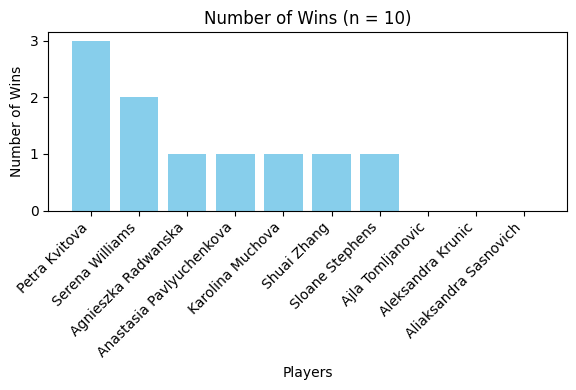

In [88]:
# n = 10:
random.seed(10)
n = 10  # Number of times to simulate the tournament
players_scoring = dict([(player, 0) for player in sorted(unique_women)])
results = simulate_tournament_multiple_times(round128players, P, n, players_scoring, last_values_df)
results = dict(sorted(results.items(), key=lambda item: item[1], reverse = True))
print("Tournament Results:")
for player, wins in results.items():
    print(f"{player}: {wins} wins")

df_sim_10 = pd.DataFrame(list(results.items()), columns=['Player', 'Wins'])
# Take the top 10 players
top_10 = df_sim_10.head(10)

# Create the histogram
plt.figure(figsize=(6, 4))
plt.bar(top_10['Player'], top_10['Wins'], color='skyblue')
plt.xlabel('Players')
plt.ylabel('Number of Wins')
plt.title('Number of Wins (n = 10)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

Tournament Results:
Maria Sharapova: 4 wins
Petra Kvitova: 2 wins
Serena Williams: 2 wins
Victoria Azarenka: 2 wins
Ekaterina Makarova: 1 wins
Julia Goerges: 1 wins
Kiki Bertens: 1 wins
Laura Siegemund: 1 wins
Lesia Tsurenko: 1 wins
Lucie Safarova: 1 wins
Samantha Stosur: 1 wins
Simona Halep: 1 wins
Timea Bacsinszky: 1 wins
Venus Williams: 1 wins
Agnieszka Radwanska: 0 wins
Ajla Tomljanovic: 0 wins
Aleksandra Krunic: 0 wins
Aliaksandra Sasnovich: 0 wins
Alison Riske: 0 wins
Alison Van Uytvanck: 0 wins
Alize Cornet: 0 wins
Amanda Anisimova: 0 wins
Ana Bogdan: 0 wins
Anastasia Pavlyuchenkova: 0 wins
Anastasija Sevastova: 0 wins
Andrea Petkovic: 0 wins
Anett Kontaveit: 0 wins
Angelique Kerber: 0 wins
Anhelina Kalinina: 0 wins
Anna Blinkova: 0 wins
Anna Kalinskaya: 0 wins
Anna Karolina Schmiedlova: 0 wins
Arantxa Rus: 0 wins
Aryna Sabalenka: 0 wins
Ashleigh Barty: 0 wins
Asia Muhammed: 0 wins
Barbora Zahlavova Strycova: 0 wins
Belinda Bencic: 0 wins
Bernarda Pera: 0 wins
Camila Giorgi: 0 w

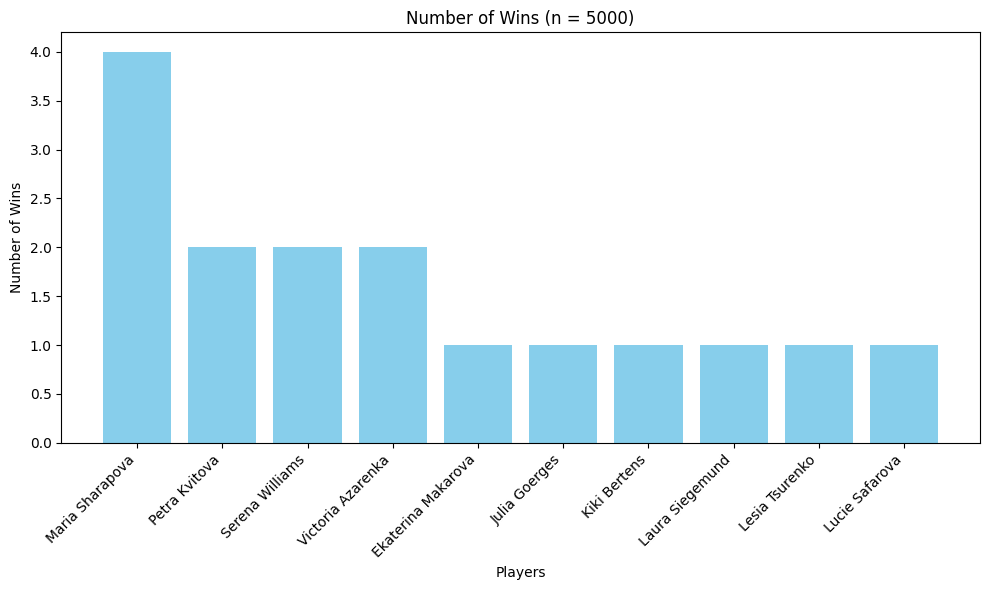

In [82]:
# n = 20:
random.seed(10)
n = 20 # Number of times to simulate the tournament
players_scoring = dict([(player, 0) for player in sorted(unique_women)])
results = simulate_tournament_multiple_times(round128players, P, n, players_scoring, last_values_df)
results = dict(sorted(results.items(), key=lambda item: item[1], reverse = True))
print("Tournament Results:")
for player, wins in results.items():
    print(f"{player}: {wins} wins")

df_sim_20 = pd.DataFrame(list(results.items()), columns=['Player', 'Wins'])
# Take the top 10 players
top_10 = df_sim_20.head(10)

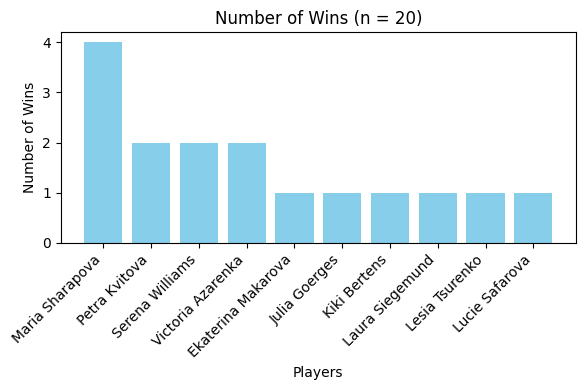

In [84]:
# Create the histogram
plt.figure(figsize=(6, 4))
plt.bar(top_10['Player'], top_10['Wins'], color='skyblue')
plt.xlabel('Players')
plt.ylabel('Number of Wins')
plt.title('Number of Wins (n = 20)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

Tournament Results:
Serena Williams: 3211 wins
Victoria Azarenka: 1136 wins
Petra Kvitova: 888 wins
Maria Sharapova: 735 wins
Venus Williams: 543 wins
Elina Svitolina: 318 wins
Simona Halep: 310 wins
Agnieszka Radwanska: 260 wins
Svetlana Kuznetsova: 208 wins
Sloane Stephens: 174 wins
Angelique Kerber: 164 wins
Karolina Pliskova: 164 wins
Samantha Stosur: 124 wins
Anastasia Pavlyuchenkova: 116 wins
Dominika Cibulkova: 98 wins
Caroline Wozniacki: 86 wins
Madison Keys: 75 wins
Vera Zvonareva: 74 wins
Johanna Konta: 67 wins
Garbine Muguruza: 64 wins
Julia Goerges: 52 wins
Laura Siegemund: 52 wins
Lucie Safarova: 52 wins
Belinda Bencic: 51 wins
Darya Kasatkina: 51 wins
Irina Camelia Begu: 45 wins
Timea Bacsinszky: 43 wins
Jelena Ostapenko: 36 wins
Daria Gavrilova: 29 wins
Carla Suarez Navarro: 28 wins
Ekaterina Makarova: 27 wins
Elise Mertens: 27 wins
Alize Cornet: 26 wins
Coco Vandeweghe: 24 wins
Ekaterina Alexandrova: 22 wins
Kathinka Von Deichmann: 20 wins
Kiki Bertens: 20 wins
Eugenie 

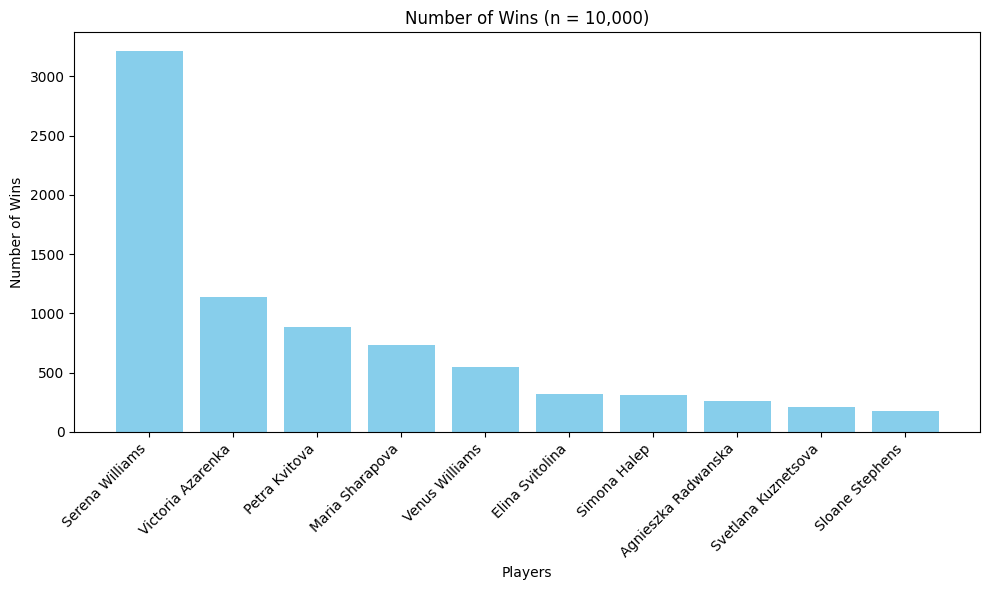

In [ ]:
# n = 100
# Example usage:
random.seed(10)
players_scoring = dict([(player, 0) for player in sorted(unique_women)])
n = 100  # Number of times to simulate the tournament
results = simulate_tournament_multiple_times(round128players, P, n, players_scoring, last_values_df)
results = dict(sorted(results.items(), key=lambda item: item[1], reverse = True))
print("Tournament Results:")
for player, wins in results.items():
    print(f"{player}: {wins} wins")

df_sim_10000 = pd.DataFrame(list(results.items()), columns=['Player', 'Wins'])
# Take the top 10 players
top_10 = df_sim_10000.head(10)

# Create the histogram
plt.figure(figsize=(10, 6))
plt.bar(top_10['Player'], top_10['Wins'], color='skyblue')
plt.xlabel('Players')
plt.ylabel('Number of Wins')
plt.title('Number of Wins (n = 100)')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

**Modify ELO to account for duration of games played throughout the tournament. Using this data, does prediction of the final winner get better?**

In [ ]:
# simulate last match
random.seed(10)
women_in_final = ['Serena Williams', 'Naomi Osaka']
women_in_final_dict = {'Serena Williams': 0, 'Naomi Osaka': 0}
winner = ''

for i in range(10000):
  winner = roundF(women_in_final, P)
  if winner == 'Serena Williams':
    women_in_final_dict['Serena Williams'] += 1
  else:
    women_in_final_dict['Naomi Osaka'] += 1

print(women_in_final_dict)

{'Serena Williams': 9198, 'Naomi Osaka': 802}


In [ ]:
# including duration as a variable
US_Open_2018_copy = US_Open_2018.copy()
US_Open_2018_copy['long_duration'] = (US_Open_2018['minutes'].astype(int) > upper_bound_mins).astype(int)
US_Open_2018_copy = US_Open_2018_copy[~(US_Open_2018_copy['round'] == 'F')]

# count number of matches above upper bound for each player
naomi_dur_mean = US_Open_2018_copy[['minutes']][US_Open_2018_copy['winner_name'] == "Naomi Osaka"].mean()
serena_dur_mean = US_Open_2018_copy[['minutes']][US_Open_2018_copy['winner_name'] == "Serena Williams"].mean()
difference_dur =  serena_dur_mean - naomi_dur_mean # note: equal to 8/3
difference_dur = 8/3

# percentage adjustment
pct_adj = (difference_dur / mean_mins)

In [ ]:
# adjust elo scores
finals_df = last_values_df[(last_values_df['Player'] == 'Naomi Osaka') | (last_values_df['Player'] == 'Serena Williams')]
serena_current = 1873.496841
serena_update = serena_current * (1-pct_adj)

data_finals = {'Player': ['Naomi Osaka', 'Serena Williams'], 'Elo Score': [1452.140332, serena_update]}
finals_df_2 = pd.DataFrame(data_finals)

,Player,Elo Score
0,Naomi Osaka,1452.140332
1,Serena Williams,1823.287857


In [ ]:
# calculate new P matrix
P2 = convert_elo_to_pair_probabilities(finals_df_2)

{'Naomi Osaka': {'Naomi Osaka': 0.5, 'Serena Williams': 0.10559979551067687},
 'Serena Williams': {'Naomi Osaka': 0.8944002044893231,
  'Serena Williams': 0.5}}

In [ ]:
# simulate last match
random.seed(10)
women_in_final = ['Serena Williams', 'Naomi Osaka']
women_in_final_dict = {'Serena Williams': 0, 'Naomi Osaka': 0}
winner = ''

for i in range(10000):
  winner = roundF(women_in_final, P2)
  if winner == 'Serena Williams':
    women_in_final_dict['Serena Williams'] += 1
  else:
    women_in_final_dict['Naomi Osaka'] += 1

print(women_in_final_dict)

{'Serena Williams': 8946, 'Naomi Osaka': 1054}
